# Detecção de fraude - cartão de crédito - Kaggle

## Introdução

Este notebook utiliza base de dados do Kaggle:
- https://www.kaggle.com/dalpozz/creditcardfraud

A base de dados contém mais de 284 mil transações de cartão de crédito contendo hora, valor e
28 atributos normalizados obtidos através de transformação PCA de redução de dimensionalidade.
Assim, ao todo são 30 atributos. O alvo do problema é prever se a transação é fraudulenta ou
genuína.
Uma característica fundamental deste dataset e que é comum em sistemas de fraudes é a diferença
entre respostas positivas: 284315 versus respostas negativas fraudulentas: 492. As fraudes 
representam apenas 0,17% das transações.
Este problema pode ser visto como sendo um problema de detecção de anomalia, entretanto iremos
tratá-la como um problema de classificação em duas classes utilizando redes neurais com
várias técnicas de regularização.

## Importação

In [1]:
%matplotlib inline
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from keras.models import Sequential, Input
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import advanced_activations
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianNoise
from keras.optimizers import RMSprop, Adam

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

Using TensorFlow backend.


## Funções de apoio ao treinamento

In [2]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Leitura dos dados

In [3]:
dataframe = pd.read_csv('/data/datasets/creditcard.csv', header=0)
dataframe.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### converte rótulos para codificação one-hot e conta número de amostras em cada classe

In [4]:
label = np.asarray(dataframe['Class'])
categorical_labels = to_categorical(label, 2)
categorical_labels.sum(axis=0)

array([ 284315.,     492.])

### Aplica mod no Timestamp para ser uma indicação da hora diária e normaliza dados 

In [5]:
df_cp = dataframe.copy()
features = np.asarray(df_cp.values)[:,:-1]
timestamp = features[:,0]
timestamp = timestamp % (60* 60 * 24) # modulo número de segundos por dia
features -= features.min(axis=0)
features /= features.max(axis=0)
features[:1],features.shape

(array([[ 0.        ,  0.93519234,  0.76649042,  0.8813649 ,  0.31302266,
          0.76343873,  0.26766864,  0.26681518,  0.7864442 ,  0.47531173,
          0.51060048,  0.25248432,  0.68090763,  0.3715906 ,  0.63559053,
          0.4460837 ,  0.43439239,  0.73717255,  0.65506586,  0.59486323,
          0.58294223,  0.56118439,  0.52299212,  0.66379298,  0.39125268,
          0.58512179,  0.39455679,  0.41897614,  0.31269663,  0.00582379]]),
 (284807, 30))

### Visualiza com boxplot

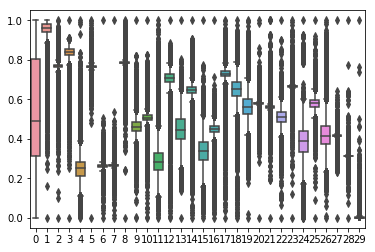

In [6]:
sns.boxplot(data=features[:,:])

## Separação dados em treinamento e teste (20%)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, categorical_labels, test_size=0.2, random_state=40)

In [8]:
FEATURE_NUM = 30
CLASSES = 2
MAX_RANGE = 100

In [9]:
print(X_train.shape)
print(y_train.sum(axis=0))

(227845, 30)
[ 227450.     395.]


## Definição da rede

In [10]:
model = Sequential()
model.add(BatchNormalization(input_shape=(FEATURE_NUM,)))
model.add(GaussianNoise(0.4))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASSES, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
__________

## Treinamento

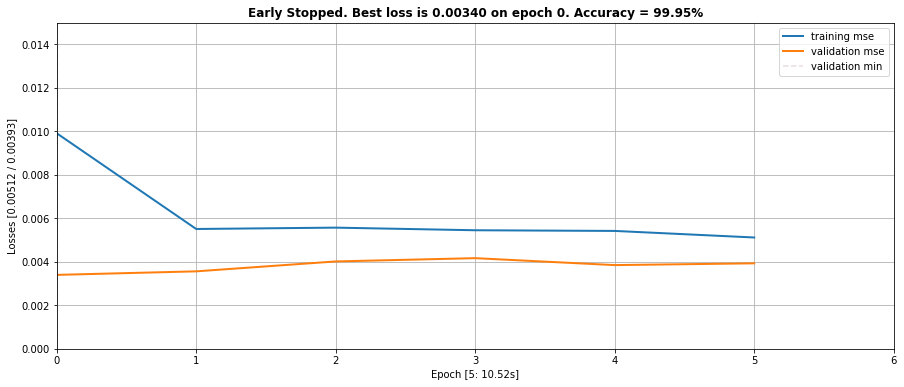

In [11]:
model_name = '../../models/creditcardfraud'
fit_params = {
    'model_name': model_name,
    'loss': 'binary_crossentropy',
    'opt':        Adam(), 
    'batch_size': 1000, 
    'nepochs':    6,
    'patience':   4,
    'ploss':      0.015,
    'reset':      False,
}

train_network(model, X_train, y_train, X_test, y_test, **fit_params);

## Avaliação

In [17]:
model, histo = load_model_and_history(model_name)
y_train_pred = model.predict_classes(X_train)
y_train_class = y_train.argmax(axis=1)
print()
print(sklearn.metrics.confusion_matrix(y_train_class,y_train_pred))
print(sklearn.metrics.classification_report(y_train_class,y_train_pred))

225728/227845 [============================>.] - ETA: 0s(227845,) (227845,)
[[227382     68]
 [    81    314]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    227450
          1       0.82      0.79      0.81       395

avg / total       1.00      1.00      1.00    227845



In [19]:
y_test_pred = model.predict_classes(X_test)
y_test_class = (y_test.argmax(axis=1))
print()
print(sklearn.metrics.confusion_matrix(y_test_class,y_test_pred))
print(sklearn.metrics.classification_report(y_test_class,y_test_pred))

55200/56962 [============================>.] - ETA: 0s
[[56851    14]
 [   14    83]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56865
          1       0.86      0.86      0.86        97

avg / total       1.00      1.00      1.00     56962



## Aprendizados